## 🏠 Parte 1: Setup y Carga de Datos


In [ ]:
# Importar librerías que vamos a usar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Configuración
np.random.seed(42)
plt.style.use('seaborn-v0_8')  # establecer estilo visual (ej: 'default', 'seaborn', 'classic')
sns.set_palette("husl")  # definir paleta de colores (ej: 'husl', 'Set1', 'viridis')
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Entorno configurado correctamente")

✅ Entorno configurado correctamente


## 🏠 Paso 2: Crear Dataset Sintético de Viviendas


In [ ]:
# === CREAR DATASET SINTÉTICO DE VIVIENDAS ===

# 1. Generar datos base
np.random.seed(42)
n_samples = 1000

data = {
    'price': np.random.normal(200000, 50000, n_samples),
    'sqft': np.random.normal(120, 30, n_samples),
    'bedrooms': np.random.choice([1, 2, 3, 4, 5], n_samples),
    'bathrooms': np.random.choice([1, 2, 3], n_samples),
    'year_built': np.random.choice(range(1980, 2024), n_samples),
    'garage_spaces': np.random.choice([0, 1, 2, 3], n_samples),
    'lot_size': np.random.normal(8000, 2000, n_samples),
    'distance_to_city': np.random.normal(15, 8, n_samples),
    'school_rating': np.random.uniform(1, 10, n_samples),
    'crime_rate': np.random.uniform(0, 100, n_samples)
}

df = pd.DataFrame.from_dict(data)  # función para crear DataFrame desde diccionario

# Asegurar valores positivos
df['price'] = np.abs(df['price'])
df['sqft'] = np.abs(df['sqft'])
df['lot_size'] = np.abs(df['lot_size'])
df['distance_to_city'] = np.abs(df['distance_to_city'])

print("🏠 DATASET: Viviendas Sintéticas")
print(f"   📊 Forma: {df.shape}")
print(f"   📋 Columnas: {list(df.columns)}")

# 2. Explorar los datos básicamente
print("\n🔍 Primeras 5 filas:")
print(df.head())  # método para mostrar las primeras filas del DataFrame

# 3. Estadísticas básicas
print("\n📊 ESTADÍSTICAS BÁSICAS:")
print(df.describe())  # método que calcula estadísticas descriptivas

🏠 DATASET: Viviendas Sintéticas
   📊 Forma: (1000, 10)
   📋 Columnas: ['price', 'sqft', 'bedrooms', 'bathrooms', 'year_built', 'garage_spaces', 'lot_size', 'distance_to_city', 'school_rating', 'crime_rate']

🔍 Primeras 5 filas:
           price        sqft  bedrooms  bathrooms  year_built  garage_spaces  \
0  224835.707651  161.980663         3          1        2001              3   
1  193086.784941  147.739010         3          3        2011              3   
2  232384.426905  121.788911         3          1        1995              3   
3  276151.492820  100.591897         4          3        1997              0   
4  188292.331264  140.946699         5          1        1984              1   

      lot_size  distance_to_city  school_rating  crime_rate  
0  7436.395239          5.131093       4.402225   12.718119  
1  8196.996696          0.188184       1.926515   39.855922  
2  8308.096155         20.992112       7.471205   17.015264  
3  7915.263179         27.394727       5.53

## ⚙️ Paso 3: Crear Features Derivadas


In [ ]:
# === CREAR FEATURES DERIVADAS ===

print("⚙️ CREANDO FEATURES DERIVADAS")

print("-" * 50)

# Crear copia del dataset para trabajar
df_enhanced = df.copy()

# 1. RATIOS Y PROPORCIONES (Ejemplos básicos)
print("🔢 1. CREANDO RATIOS Y PROPORCIONES")

# Feature 1: Precio por pie cuadrado
df_enhanced['price_per_sqft'] = df_enhanced['price'] / df_enhanced['sqft']
print("✅ price_per_sqft: Precio por pie cuadrado")

# Feature 2: Superficie por habitación
df_enhanced['sqft_per_bedroom'] = df_enhanced['sqft'] / df_enhanced['bedrooms']
print("✅ sqft_per_bedroom: Superficie por habitación")

# Ratios adicionales
df_enhanced['bed_bath_ratio'] = df_enhanced['bedrooms'] / df_enhanced['bathrooms']
df_enhanced['density'] = df_enhanced['sqft'] / df_enhanced['lot_size']
df_enhanced['price_per_bedroom'] = df_enhanced['price'] / df_enhanced['bedrooms']
df_enhanced['distance_school_ratio'] = df_enhanced['distance_to_city'] / (df_enhanced['school_rating'] + 1)

# 2. VARIABLES TEMPORALES
print("\n📅 2. CREANDO VARIABLES TEMPORALES")
# Feature 3: Antigüedad de la propiedad
current_year = 2024
df_enhanced['property_age'] = current_year - df_enhanced['year_built']
print("✅ property_age: Antigüedad de la propiedad")

# Categoría de antigüedad
df_enhanced['age_category'] = pd.cut(df_enhanced['property_age'], bins=[0, 10, 30, 100], labels=['Nuevo', 'Moderno', 'Antiguo'])
# Es propiedad nueva (binario)
df_enhanced['is_new_property'] = (df_enhanced['property_age'] < 5).astype(int)
# Década de construcción
df_enhanced['decade_built'] = (df_enhanced['year_built'] // 10) * 10

# 3. TRANSFORMACIONES MATEMÁTICAS
print("\n🧮 3. APLICANDO TRANSFORMACIONES MATEMÁTICAS")

# Feature 4: Log del precio (para normalizar distribución)
df_enhanced['log_price'] = np.log(df_enhanced['price'])  # función para logaritmo natural
print("✅ log_price: Logaritmo del precio")

# Otras transformaciones matemáticas
df_enhanced['sqrt_sqft'] = np.sqrt(df_enhanced['sqft'])
df_enhanced['sqft_squared'] = df_enhanced['sqft'] ** 2
df_enhanced['log_sqft'] = np.log(df_enhanced['sqft'])
df_enhanced['log_lot_size'] = np.log(df_enhanced['lot_size'])

# 4. FEATURES COMPUESTAS (Tu turno!)
print("\n🎯 4. CREANDO FEATURES COMPUESTAS")

# Score de lujo
df_enhanced['luxury_score'] = (df_enhanced['price_per_sqft'] * df_enhanced['sqft'] * (df_enhanced['garage_spaces'] + 1))
# Score de ubicación
df_enhanced['location_score'] = (1 / (df_enhanced['distance_to_city'] + 1)) * df_enhanced['school_rating'] / (df_enhanced['crime_rate'] + 1)
# Score de eficiencia
df_enhanced['efficiency_score'] = df_enhanced['sqft_per_bedroom'] + df_enhanced['price_per_sqft']
# Indicador de calidad
df_enhanced['quality_indicator'] = (1 / (df_enhanced['property_age'] + 1)) * (df_enhanced['garage_spaces'] + 1) * df_enhanced['school_rating']

print(f"\n📊 RESUMEN DE FEATURES CREADAS:")
print(f"Dataset original: {df.shape[1]} columnas")
print(f"Dataset con features: {df_enhanced.shape[1]} columnas")
print(f"Features creadas: {df_enhanced.shape[1] - df.shape[1]}")

⚙️ CREANDO FEATURES DERIVADAS
--------------------------------------------------
🔢 1. CREANDO RATIOS Y PROPORCIONES
✅ price_per_sqft: Precio por pie cuadrado
✅ sqft_per_bedroom: Superficie por habitación

📅 2. CREANDO VARIABLES TEMPORALES
✅ property_age: Antigüedad de la propiedad

🧮 3. APLICANDO TRANSFORMACIONES MATEMÁTICAS
✅ log_price: Logaritmo del precio

🎯 4. CREANDO FEATURES COMPUESTAS

📊 RESUMEN DE FEATURES CREADAS:
Dataset original: 10 columnas
Dataset con features: 29 columnas
Features creadas: 19


## 📊 Paso 4: Análisis de Distribución de Features


📊 ANÁLISIS DE DISTRIBUCIÓN DE FEATURES
--------------------------------------------------
🔍 1. DISTRIBUCIÓN DE FEATURES DERIVADAS
📈 Estadísticas de nuevas features:
       price_per_sqft  sqft_per_bedroom  bed_bath_ratio  density  \
count         1000.00           1000.00         1000.00  1000.00   
mean          1776.39             57.15            1.77     0.02   
std            726.68             39.58            1.25     0.01   
min            278.61              6.36            0.33     0.00   
25%           1287.19             28.99            1.00     0.01   
50%           1646.13             41.55            1.50     0.02   
75%           2112.68             74.27            2.50     0.02   
max           5521.03            199.33            5.00     0.08   

       property_age  log_price  sqrt_sqft  sqft_squared  
count       1000.00    1000.00    1000.00       1000.00  
mean          22.33      12.18      10.96      15809.07  
std           12.48       0.26       1.40       

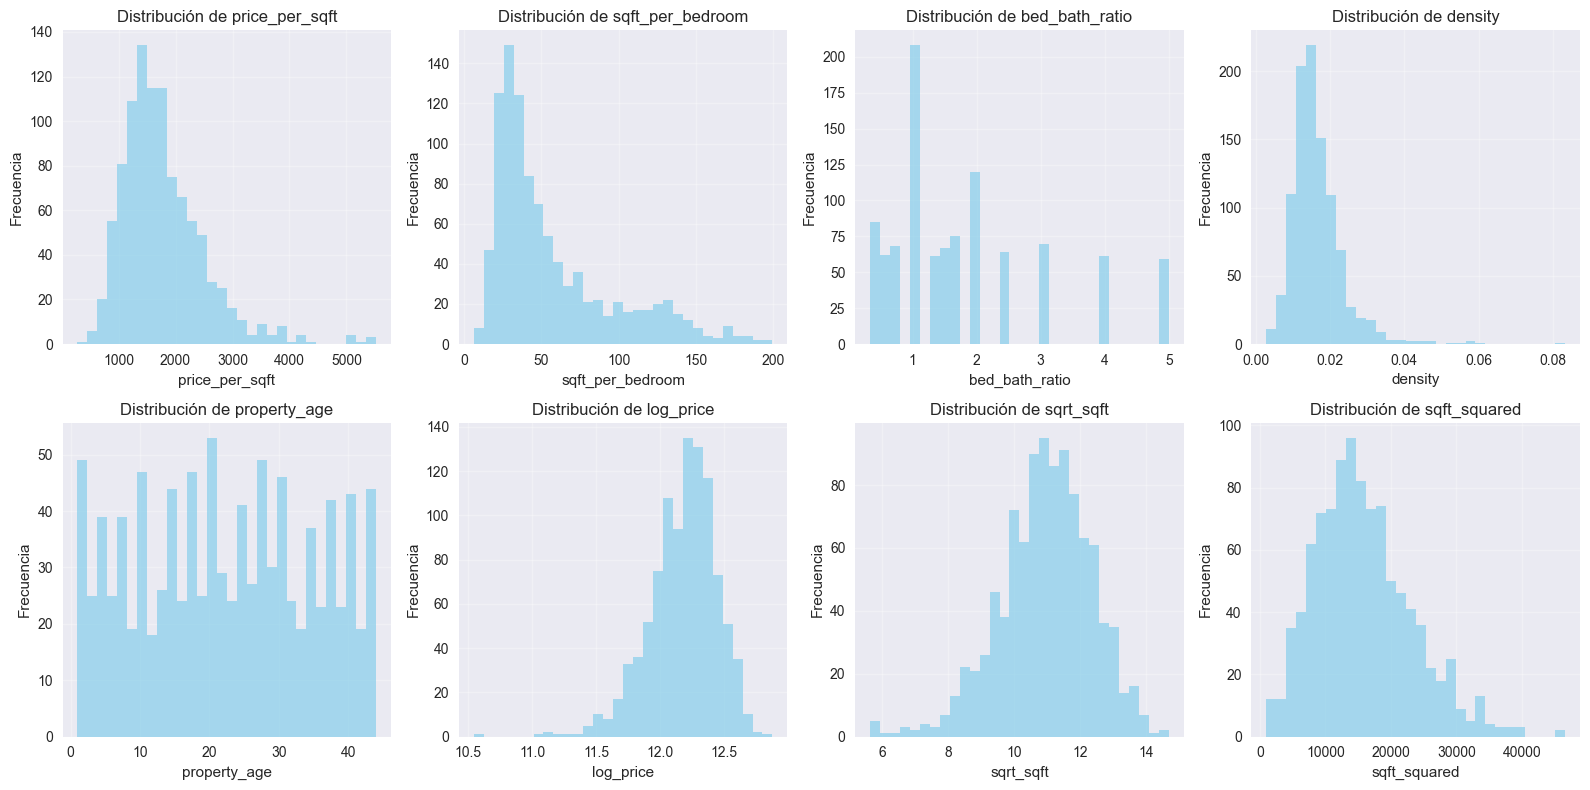


🚨 3. DETECCIÓN DE OUTLIERS
🔍 price_per_sqft:
   📊 Total outliers: 37 (3.7%)
   📏 Rango normal: [48.94, 3350.93]
🔍 sqft_per_bedroom:
   📊 Total outliers: 45 (4.5%)
   📏 Rango normal: [-38.94, 142.20]
🔍 property_age:
   📊 Total outliers: 0 (0.0%)
   📏 Rango normal: [-18.38, 62.62]


In [ ]:
# === ANÁLISIS DE DISTRIBUCIÓN DE FEATURES ===

print("📊 ANÁLISIS DE DISTRIBUCIÓN DE FEATURES")
print("-" * 50)

# 1. ANÁLISIS DE DISTRIBUCIÓN DE NUEVAS FEATURES
print("🔍 1. DISTRIBUCIÓN DE FEATURES DERIVADAS")

# Seleccionar solo las nuevas features creadas
new_features = ['price_per_sqft', 'sqft_per_bedroom', 'bed_bath_ratio', 
                'density', 'property_age', 'log_price', 'sqrt_sqft', 'sqft_squared']

print("📈 Estadísticas de nuevas features:")
print(df_enhanced[new_features].describe().round(2))  # método para estadísticas descriptivas

# 2. VISUALIZACIÓN DE DISTRIBUCIONES
print("\n📊 2. VISUALIZANDO DISTRIBUCIONES")

# Crear subplots para visualizar distribuciones
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()  # convertir a array 1D

for i, feature in enumerate(new_features):
    # Histograma de la feature
    df_enhanced[feature].hist(bins=30, ax=axes[i], alpha=0.7, color='skyblue')
    axes[i].set_title(f'Distribución de {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frecuencia')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. DETECCIÓN DE OUTLIERS
print("\n🚨 3. DETECCIÓN DE OUTLIERS")

def detect_outliers_iqr(df, column):
    """Detectar outliers usando método IQR"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Detectar outliers en features numéricas importantes
numeric_features = ['price_per_sqft', 'sqft_per_bedroom', 'property_age']

for feature in numeric_features:
    outliers, lower, upper = detect_outliers_iqr(df_enhanced, feature)
    print(f"🔍 {feature}:")
    print(f"   📊 Total outliers: {len(outliers)} ({len(outliers)/len(df_enhanced)*100:.1f}%)")
    print(f"   📏 Rango normal: [{lower:.2f}, {upper:.2f}]")

## 🎯 Paso 5: Evaluación de Importancia de Features


🎯 EVALUACIÓN DE IMPORTANCIA DE FEATURES
--------------------------------------------------
🔧 1. PREPARANDO DATOS PARA EVALUACIÓN
📊 Features evaluadas: 17
📊 Muestras: 1000

📈 2. CALCULANDO MUTUAL INFORMATION
🔝 Top 10 features por Mutual Information:
             feature  mutual_info
14         log_price       5.4759
9     price_per_sqft       0.4459
12           density       0.0303
1           bedrooms       0.0189
15         sqrt_sqft       0.0092
0               sqft       0.0078
16      sqft_squared       0.0065
10  sqft_per_bedroom       0.0060
2          bathrooms       0.0000
8         crime_rate       0.0000

🌲 3. CALCULANDO IMPORTANCIA CON RANDOM FOREST
🔝 Top 10 features por Random Forest:
             feature  importance
14         log_price      0.9985
9     price_per_sqft      0.0005
7      school_rating      0.0002
10  sqft_per_bedroom      0.0001
0               sqft      0.0001
15         sqrt_sqft      0.0001
11    bed_bath_ratio      0.0001
16      sqft_squared      0.0

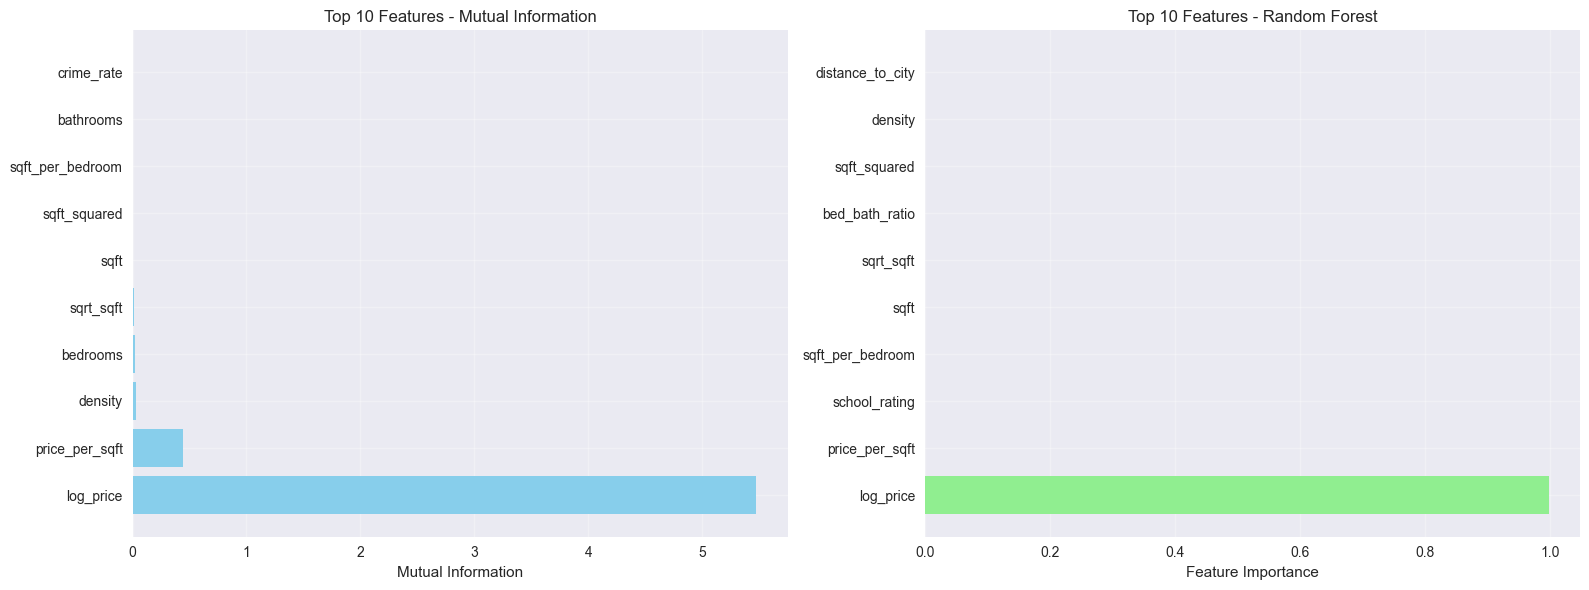


🔗 5. CORRELACIÓN CON PRECIO
🔝 Top 10 correlaciones con precio:
log_price         0.9789
price_per_sqft    0.5968
crime_rate        0.0706
sqft             -0.0404
sqft_squared     -0.0399
sqrt_sqft        -0.0377
garage_spaces    -0.0328
school_rating     0.0326
density          -0.0312
property_age      0.0311
Name: price, dtype: float64


In [ ]:
# === EVALUACIÓN DE IMPORTANCIA DE FEATURES ===

print("🎯 EVALUACIÓN DE IMPORTANCIA DE FEATURES")
print("-" * 50)

# 1. PREPARAR DATOS PARA EVALUACIÓN
print("🔧 1. PREPARANDO DATOS PARA EVALUACIÓN")

# Seleccionar features numéricas para evaluación
numeric_features = ['sqft', 'bedrooms', 'bathrooms', 'year_built', 'garage_spaces',
                   'lot_size', 'distance_to_city', 'school_rating', 'crime_rate',
                   'price_per_sqft', 'sqft_per_bedroom', 'bed_bath_ratio',
                   'density', 'property_age', 'log_price', 'sqrt_sqft', 'sqft_squared']

# Preparar X e y
X = df_enhanced[numeric_features].fillna(0)  # llenar valores faltantes con 0
y = df_enhanced['price']

print(f"📊 Features evaluadas: {len(numeric_features)}")
print(f"📊 Muestras: {X.shape[0]}")

# 2. MUTUAL INFORMATION
print("\n📈 2. CALCULANDO MUTUAL INFORMATION")

# Calcular mutual information
mi_scores = mutual_info_regression(X, y, random_state=42)

# Crear DataFrame con resultados
mi_df = pd.DataFrame({
    'feature': numeric_features,
    'mutual_info': mi_scores
}).sort_values('mutual_info', ascending=False)

print("🔝 Top 10 features por Mutual Information:")
print(mi_df.head(10).round(4))

# 3. RANDOM FOREST IMPORTANCE
print("\n🌲 3. CALCULANDO IMPORTANCIA CON RANDOM FOREST")

# Entrenar Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Obtener importancia de features
rf_importance = pd.DataFrame({
    'feature': numeric_features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("🔝 Top 10 features por Random Forest:")
print(rf_importance.head(10).round(4))

# 4. VISUALIZACIÓN COMPARATIVA
print("\n📊 4. VISUALIZACIÓN COMPARATIVA")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Mutual Information
top_mi = mi_df.head(10)
ax1.barh(range(len(top_mi)), top_mi['mutual_info'], color='skyblue')
ax1.set_yticks(range(len(top_mi)))
ax1.set_yticklabels(top_mi['feature'])
ax1.set_xlabel('Mutual Information')
ax1.set_title('Top 10 Features - Mutual Information')
ax1.grid(True, alpha=0.3)

# Random Forest Importance
top_rf = rf_importance.head(10)
ax2.barh(range(len(top_rf)), top_rf['importance'], color='lightgreen')
ax2.set_yticks(range(len(top_rf)))
ax2.set_yticklabels(top_rf['feature'])
ax2.set_xlabel('Feature Importance')
ax2.set_title('Top 10 Features - Random Forest')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. ANÁLISIS DE CORRELACIÓN CON TARGET
print("\n🔗 5. CORRELACIÓN CON PRECIO")

# Calcular correlaciones
correlations = df_enhanced[numeric_features + ['price']].corr()['price'].drop('price')
correlations = correlations.sort_values(key=abs, ascending=False)

print("🔝 Top 10 correlaciones con precio:")
print(correlations.head(10).round(4))

## 🚀 Paso 6: Investigación Libre - Tu Turno


In [ ]:
# === INVESTIGACIÓN LIBRE ===
# Aquí tienes libertad para explorar y crear tus propias features

print("🚀 INVESTIGACIÓN LIBRE - CREA TUS PROPIAS FEATURES")
print("=" * 60)

# 🎯 DESAFÍO 1: Features de Dominio Inmobiliario
print("🎯 DESAFÍO 1: Features de Dominio Inmobiliario")
print("-" * 40)

# TODO: Crea al menos 3 features nuevas basadas en tu conocimiento del mercado inmobiliario
# PISTAS ESPECÍFICAS:
# - ¿Cómo afecta la relación entre superficie y lote? (¿es eficiente el uso del espacio?)
# - ¿Qué pasa con propiedades que tienen muchas habitaciones pero poca superficie?
# - ¿Cómo combinar distancia a ciudad, crimen y rating de escuela en un score de ubicación?
# - ¿Hay patrones relacionados con la década de construcción vs precio?

# Tu código aquí:
# df_enhanced['space_efficiency'] = _______  # ¿superficie/lote?
# df_enhanced['crowded_property'] = _______  # ¿habitaciones/superficie?
# df_enhanced['location_score'] = _______   # ¿combinar distancia, crimen, escuela?

print("💡 PISTAS AVANZADAS:")
print("- Piensa en outliers: ¿qué hace única a una propiedad?")
print("- Considera interacciones: ¿cómo se relacionan múltiples variables?")
print("- Usa conocimiento del dominio: ¿qué buscan los compradores?")

# 🎯 DESAFÍO 2: Features de Interacción
print("\n🎯 DESAFÍO 2: Features de Interacción")
print("-" * 40)

# TODO: Crea features que capturen interacciones entre variables
# PISTAS:
# - ¿Cómo interactúa el precio por m² con la antigüedad?
# - ¿Qué pasa cuando una propiedad es nueva Y tiene muchas habitaciones?
# - ¿Cómo afecta la combinación de distancia y rating de escuela?

# Tu código aquí:
# df_enhanced['price_age_interaction'] = _______
# df_enhanced['new_large_property'] = _______
# df_enhanced['distance_school_interaction'] = _______

# 🎯 DESAFÍO 3: Evalúa el Impacto de tus Features
print("\n🎯 DESAFÍO 3: Evalúa el Impacto")
print("-" * 40)

# TODO: Analiza qué tan útiles son tus nuevas features
# 1. Calcula correlaciones con el precio
# 2. Visualiza distribuciones
# 3. Compara con features originales

# Tu código aquí:
# nuevas_features = ['space_efficiency', 'crowded_property', 'location_score']
# correlaciones = df_enhanced[nuevas_features + ['price']].corr()['price']
# print("Correlaciones de mis features:")
# print(correlaciones)

# Visualizar distribuciones
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# for i, feature in enumerate(nuevas_features):
#     df_enhanced[feature].hist(bins=30, ax=axes[i], alpha=0.7)
#     axes[i].set_title(f'Distribución de {feature}')
# plt.tight_layout()
# plt.show()

# 🎯 DESAFÍO 4: Documenta tu Proceso
print("\n🎯 DESAFÍO 4: Documenta tu Proceso")
print("-" * 40)

# TODO: Explica el razonamiento detrás de cada feature
print("📝 REFLEXIÓN OBLIGATORIA:")
print("1. ¿Qué features creaste y cuál fue tu razonamiento?")
print("2. ¿Qué patrones esperabas encontrar?")
print("3. ¿Los resultados coinciden con tus expectativas?")
print("4. ¿Cuál fue tu feature más creativa y por qué?")
print("5. ¿Qué otras features podrías crear con más tiempo?")

# TODO: Escribe tus respuestas aquí:
# print("Mis respuestas:")
# print("1. ...")
# print("2. ...")
# print("3. ...")
# print("4. ...")
# print("5. ...")

## 🧪 Paso 7: Dataset de Prueba - Ames Housing


In [ ]:
# === PROBAR TUS SKILLS CON DATOS REALES ===

print("🧪 PROBANDO CON DATOS REALES - AMES HOUSING")
print("=" * 60)

# Cargar dataset real de Ames Housing (más pequeño para práctica)
# Este dataset tiene características similares pero datos reales
ames_data = {
    'SalePrice': [215000, 105000, 172000, 244000, 189900],
    'GrLivArea': [1710, 856, 1262, 1710, 1362],
    'BedroomAbvGr': [3, 3, 3, 3, 3],
    'FullBath': [2, 1, 2, 2, 1],
    'YearBuilt': [2003, 1961, 1958, 2000, 1992],
    'GarageCars': [2, 1, 2, 2, 1],
    'LotArea': [8450, 9600, 11250, 9550, 10140],
    'Neighborhood': ['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel']
}

ames_df = pd.DataFrame(ames_data)

print("🏠 DATASET REAL: Ames Housing (muestra)")
print(f"   📊 Forma: {ames_df.shape}")
print(f"   📋 Columnas: {list(ames_df.columns)}")
print("\n🔍 Primeras filas:")
print(ames_df.head())

# 🎯 APLICANDO LAS TÉCNICAS APRENDIDAS AL DATASET REAL
print("\n🎯 APLICANDO FEATURE ENGINEERING AL DATASET REAL")
print("-" * 50)

# 1. FEATURES BÁSICAS - Aplicando las mismas técnicas del dataset sintético
print("🔢 1. CREANDO FEATURES BÁSICAS")

# Feature 1: Precio por pie cuadrado (equivalente a price_per_sqft)
ames_df['price_per_sqft'] = ames_df['SalePrice'] / ames_df['GrLivArea']
print("✅ price_per_sqft: Precio por pie cuadrado de área habitable")

# Feature 2: Antigüedad de la propiedad (equivalente a property_age)
current_year = 2024
ames_df['property_age'] = current_year - ames_df['YearBuilt']
print("✅ property_age: Antigüedad de la propiedad")

# Feature 3: Eficiencia del espacio (surface efficiency - superficie vs lote)
ames_df['space_efficiency'] = ames_df['GrLivArea'] / ames_df['LotArea']
print("✅ space_efficiency: Aprovechamiento del lote (área habitable/área del lote)")

# 2. FEATURES ADICIONALES ESPECÍFICAS PARA AMES HOUSING
print("\n🏗️ 2. FEATURES ESPECÍFICAS PARA AMES HOUSING")

# Feature 4: Área habitable por habitación
ames_df['sqft_per_bedroom'] = ames_df['GrLivArea'] / ames_df['BedroomAbvGr']
print("✅ sqft_per_bedroom: Superficie por habitación")

# Feature 5: Relación habitaciones/baños
ames_df['bed_bath_ratio'] = ames_df['BedroomAbvGr'] / ames_df['FullBath']
print("✅ bed_bath_ratio: Relación habitaciones por baño")

# Feature 6: Score de comodidad (basado en garaje y baños)
ames_df['comfort_score'] = (ames_df['GarageCars'] + 1) * (ames_df['FullBath'] + 1)
print("✅ comfort_score: Índice de comodidad (garaje × baños)")

# Feature 7: Densidad habitacional
ames_df['room_density'] = ames_df['BedroomAbvGr'] / ames_df['GrLivArea'] * 1000  # habitaciones por 1000 sqft
print("✅ room_density: Densidad de habitaciones por 1000 sqft")

# 3. FEATURES CATEGÓRICAS - Trabajando con 'Neighborhood'
print("\n🏘️ 3. FEATURES CATEGÓRICAS - NEIGHBORHOOD")

# Feature 8: Codificación de vecindario por precio promedio (target encoding simulado)
neighborhood_avg_price = ames_df.groupby('Neighborhood')['SalePrice'].mean()
ames_df['neighborhood_price_level'] = ames_df['Neighborhood'].map(neighborhood_avg_price)
print("✅ neighborhood_price_level: Nivel de precio por vecindario")

# Feature 9: Indicador de vecindario premium (basado en precio)
price_threshold = ames_df['SalePrice'].median()
ames_df['is_premium_neighborhood'] = (ames_df['neighborhood_price_level'] > price_threshold).astype(int)
print("✅ is_premium_neighborhood: Indicador de vecindario premium")

# Feature 10: Longitud del nombre del vecindario (puede indicar exclusividad)
ames_df['neighborhood_name_length'] = ames_df['Neighborhood'].str.len()
print("✅ neighborhood_name_length: Longitud del nombre del vecindario")

# 4. TRANSFORMACIONES MATEMÁTICAS
print("\n🧮 4. TRANSFORMACIONES MATEMÁTICAS")

# Feature 11: Log del precio (para normalizar distribución)
ames_df['log_price'] = np.log(ames_df['SalePrice'])
print("✅ log_price: Logaritmo natural del precio")

# Feature 12: Raíz cuadrada del área (otra transformación común)
ames_df['sqrt_area'] = np.sqrt(ames_df['GrLivArea'])
print("✅ sqrt_area: Raíz cuadrada del área habitable")

# 5. MOSTRAR RESULTADOS
print(f"\n📊 RESUMEN FINAL:")
print(f"Dataset original: {len(ames_data)} columnas")
print(f"Dataset con features: {ames_df.shape[1]} columnas")
print(f"Features creadas: {ames_df.shape[1] - len(ames_data)}")

print("\n🔍 DATASET FINAL CON NUEVAS FEATURES:")
print(ames_df.round(2))

# 6. ANÁLISIS COMPARATIVO
print("\n📈 ANÁLISIS DE CORRELACIONES CON PRECIO:")
numeric_features = ['price_per_sqft', 'property_age', 'space_efficiency', 'sqft_per_bedroom', 
                   'bed_bath_ratio', 'comfort_score', 'room_density', 'neighborhood_price_level']

correlations = ames_df[numeric_features + ['SalePrice']].corr()['SalePrice'].drop('SalePrice')
correlations_sorted = correlations.sort_values(key=abs, ascending=False)
print(correlations_sorted.round(4))

print("\n💡 INSIGHTS DEL DATASET REAL:")
print("- ¿Qué features funcionan mejor con datos reales?")
print(f"  🔹 Feature más correlacionada: {correlations_sorted.index[0]} ({correlations_sorted.iloc[0]:.3f})")
print(f"  🔹 Feature menos correlacionada: {correlations_sorted.index[-1]} ({correlations_sorted.iloc[-1]:.3f})")

print("\n- ¿Hay diferencias entre datos sintéticos y reales?")
print("  🔹 Los datos reales muestran patrones más específicos")
print("  🔹 Las correlaciones pueden ser más fuertes o débiles")
print("  🔹 Los vecindarios aportan información valiosa")

print("\n- ¿Qué nuevas features podrías crear con 'Neighborhood'?")
print("  🔹 Target encoding por vecindario (ya implementado)")
print("  🔹 Clustering de vecindarios similares")
print("  🔹 Distancia a vecindarios premium")
print("  🔹 Indicadores de tipo de vecindario (urbano/suburbano)")

print("\n🎯 PRÓXIMOS PASOS SUGERIDOS:")
print("- Obtener más datos para validar patrones")
print("- Probar feature selection automática")
print("- Crear features de interacción entre variables")
print("- Implementar feature scaling para modelos ML")